In [ ]:
!mkdir sibi
!cp /content/drive/MyDrive/Fastwork/sibi-aug-v2.zip /content/sibi
!unzip /content/sibi/sibi-aug-v2.zip -d /content/sibi
!rm /content/sibi/sibi-aug-v2.zip

In [ ]:
!mkdir sibi-v1
!cp /content/drive/MyDrive/Fastwork/sibi-crop-v1.zip /content/sibi-v1
!unzip /content/sibi-v1/sibi-crop-v1.zip -d /content/sibi-v1
!rm /content/sibi-v1/sibi-crop-v1.zip

# Library

In [1]:
!pip install split-folders -q

In [2]:
import os
import cv2
import pandas as pd
import numpy as np
import splitfolders
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Embedding, LSTM, Dense
from tensorflow.keras.layers import Flatten,BatchNormalization
from tensorflow.keras.layers import Dense, MaxPooling2D,Conv2D
from tensorflow.keras.layers import Input,Activation,Add
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# CNN SIBI

In [ ]:
# split data
splitfolders.ratio('/content/sibi', output="/content/sibi-model", seed=42, ratio=(.7, .3))

Copying files: 3006 files [00:02, 1110.35 files/s]


In [ ]:
def get_images(directory):
    Images = []
    Labels = []

    label_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8,
                     'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17,
                     'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}

    for label in os.listdir(directory):
        for image_file in os.listdir(os.path.join(directory, label)):
            image = cv2.imread(os.path.join(directory, label, image_file))
            image = cv2.resize(image, (224, 224))
            image = image.astype('float32') / 255.0
            Images.append(image)
            Labels.append(label_mapping[label])

    return shuffle(Images, Labels)

In [ ]:
train_dir = '/content/sibi-model/train'
val_dir = '/content/sibi-model/val'

data_train, train_labels = get_images(train_dir)
data_val, val_labels = get_images(val_dir)

data_train = np.array(data_train)
train_labels = np.array(train_labels)

data_val = np.array(data_val)
val_labels = np.array(val_labels)

In [ ]:
train_shape = data_train.shape
val_shape = data_val.shape

print(f"Terdapat {train_shape[0]} contoh dengan bentuk ({train_shape[1]}, {train_shape[2]}) pada data gambar latih")
print(f"Terdapat {val_shape[0]} contoh dengan bentuk ({val_shape[1]}, {val_shape[2]}) pada data gambar uji")

Terdapat 2095 contoh dengan bentuk (224, 224) pada data gambar latih
Terdapat 911 contoh dengan bentuk (224, 224) pada data gambar uji


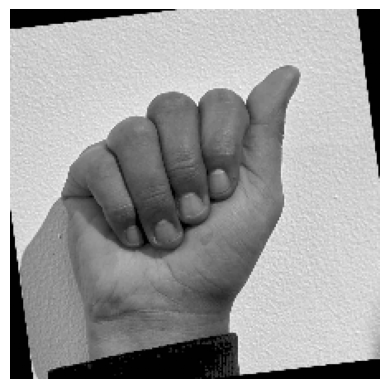

LABEL: 0


In [ ]:
idx = 423
plt.imshow(data_train[idx], cmap='gray')
plt.axis('off')
plt.show()
print(f'LABEL: {train_labels[idx]}')

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
train_labels = to_categorical(train_labels)
val_labels = to_categorical(val_labels)

In [2]:
input = Input(shape = (224,224,3))

conv1 = Conv2D(32,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(input)
conv1 = Dropout(0.4)(conv1)
conv1 = Activation('relu')(conv1)
pool1 = MaxPooling2D(pool_size = (2,2)) (conv1)

conv2 = Conv2D(64,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool1)
conv2 = Dropout(0.4)(conv2)
conv2 = Activation('relu')(conv2)
pool2 = MaxPooling2D(pool_size = (2,2)) (conv2)

conv3 = Conv2D(128,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool2)
conv3 = Dropout(0.5)(conv3)
conv3 = Activation('relu')(conv3)
pool3 = MaxPooling2D(pool_size = (2,2)) (conv3)

conv4 = Conv2D(256,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool3)
conv4 = Dropout(0.5)(conv4)
conv4 = Activation('relu')(conv4)
pool4 = MaxPooling2D(pool_size = (2,2)) (conv4)

flatten = Flatten()(pool4)

dense_1 = Dense(128,activation='relu')(flatten)

drop_1 = Dropout(0.5)(dense_1)

output = Dense(26,activation="softmax")(drop_1)

model = Model(inputs=input, outputs=output)

In [ ]:
Adam = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    name='Adam'
)

In [5]:
# proses kompilasi model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam,
              metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,814,428 (25.99 MB)

 Trainable params: 6,814,426 (25.99 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='accuracy',
                               patience=5,
                               mode='max',
                               start_from_epoch=10,
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='accuracy',
                              factor=0.5,
                              patience=3,
                              min_lr=1e-6,
                              verbose=1)

In [ ]:
checkpointer = ModelCheckpoint("model-sibi.h5", monitor='loss',verbose=1,save_best_only=True,
                               save_weights_only=False, mode='auto',save_freq='epoch')
callback_list=[checkpointer,early_stopping,reduce_lr]

In [ ]:
history = model.fit(data_train,
                    train_labels,
                    epochs=40,
                    validation_data=(data_val, val_labels),
                    callbacks=[early_stopping, reduce_lr]
                    )

Epoch 1/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 23s 206ms/step - accuracy: 0.1084 - loss: 3.7575 - val_accuracy: 0.8946 - val_loss: 2.3970 - learning_rate: 0.0010
Epoch 2/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 71ms/step - accuracy: 0.7791 - loss: 0.8858 - val_accuracy: 0.9868 - val_loss: 1.1218 - learning_rate: 0.0010
Epoch 3/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.8957 - loss: 0.4528 - val_accuracy: 0.9967 - val_loss: 0.9382 - learning_rate: 0.0010
Epoch 4/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.9284 - loss: 0.3370 - val_accuracy: 0.9978 - val_loss: 0.5221 - learning_rate: 0.0010
Epoch 5/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.9509 - loss: 0.2645 - val_accuracy: 0.9989 - val_loss: 0.7727 - learning_rate: 0.0010
Epoch 6/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.9597 - loss: 0.2116 - val_accuracy: 0.9989 - val_loss: 0.6035 - learning_rate: 0.0010
Epoch 7/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.9646 - loss: 0.2077 - val_

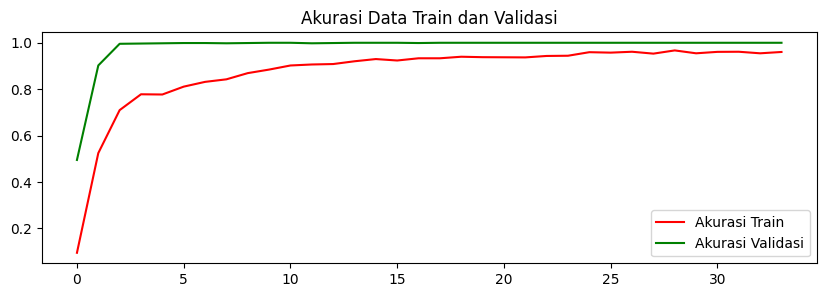

In [ ]:
# grafik akurasi data train dan validasi
akurasi = history.history['accuracy']
akurasi_val = history.history['val_accuracy']

epochs = range(len(akurasi))

plt.figure(figsize=(10, 3))
plt.plot(epochs, akurasi, 'r', label='Akurasi Train')
plt.plot(epochs, akurasi_val, 'g', label='Akurasi Validasi')
plt.title("Akurasi Data Train dan Validasi")
plt.legend(loc=4)

plt.show()

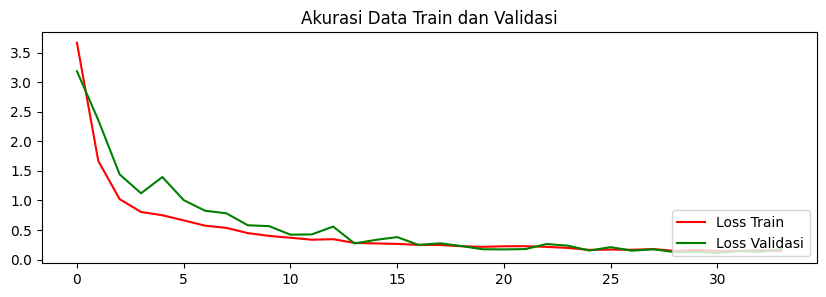

In [ ]:
# grafik akurasi data train dan validasi
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(akurasi))

plt.figure(figsize=(10, 3))
plt.plot(epochs, loss, 'r', label='Loss Train')
plt.plot(epochs, val_loss, 'g', label='Loss Validasi')
plt.title("Akurasi Data Train dan Validasi")
plt.legend(loc=4)

plt.show()

In [ ]:
loss_train, accuracy_train = model.evaluate(data_train, train_labels)
loss_val, accuracy_val = model.evaluate(data_val, val_labels)

print('Accuracy data train:', accuracy_train)
print('Accuracy data validasi:', accuracy_val)

66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 1.0000 - loss: 0.1245
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 1.0000 - loss: 0.1218
Accuracy data train: 1.0
Accuracy data validasi: 1.0


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

predictions = model.predict(data_val)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(val_labels, axis=1)

class_report = classification_report(true_labels, predicted_labels)

print("Classification Report:")
print(class_report)

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      1.00      1.00        28
           2       1.00      1.00      1.00        28
           3       1.00      1.00      1.00        28
           4       1.00      1.00      1.00        26
           5       1.00      1.00      1.00        36
           6       1.00      1.00      1.00        36
           7       1.00      1.00      1.00        36
           8       1.00      1.00      1.00        36
           9       1.00      1.00      1.00        36
          10       1.00      1.00      1.00        36
          11       1.00      1.00      1.00        31
          12       1.00      1.00      1.00        36
          13       1.00      1.00      1.00        29
          14       1.00      1.00      1.00        44
          15       1.00      1.00      1.00        24
          16      

In [ ]:
model.save('sibi-model-23052025-plat-arch-aug-v2.h5')  # Simpan seluruh model dalam format HDF5

# RNN Teks

In [ ]:
kata_dict = {
    'A': ['Aku', 'Ayah', 'Anda', 'Air', 'Apa', 'Ada', 'Atau', 'Ambil', 'Anak', 'Adik'],
    'B': ['Buku', 'Baik', 'Besar', 'Belajar', 'Benar', 'Bagus', 'Buah', 'Biru', 'Bisa', 'Bantuan'],
    'C': ['Cinta', 'Cantik', 'Coba', 'Cerita', 'Cari', 'Cahaya', 'Cepat', 'Cuaca', 'Cukup', 'Ceria'],
    'D': ['Dia', 'Dengan', 'Dan', 'Dari', 'Dalam', 'Dapat', 'Datang', 'Duduk', 'Doa', 'Damai'],
    'E': ['Enak', 'Engkau', 'Emas', 'Emosi', 'Elang', 'Ekonomi', 'Energi', 'Evaluasi', 'Evolusi', 'Ekspor'],
    'F': ['Foto', 'Film', 'Fisik', 'Filosofi', 'Faktor', 'Fantasi', 'Festival', 'Fokus', 'Formal', 'Fragmen'],
    'G': ['Gembira', 'Guru', 'Gambar', 'Gigi', 'Gunung', 'Garam', 'Gelap', 'Gadis', 'Gereja', 'Garis'],
    'H': ['Hati', 'Hari', 'Hidup', 'Harus', 'Harapan', 'Hijau', 'Hujan', 'Hebat', 'Hormat', 'Hewan'],
    'I': ['Ini', 'Itu', 'Ibu', 'Indah', 'Indonesia', 'Ingin', 'Istri', 'Ikan', 'Ilmu', 'Impian'],
    'J': ['Jangan', 'Jalan', 'Jauh', 'Juga', 'Jadi', 'Jam', 'Jantung', 'Jeruk', 'Jiwa', 'Jendela'],
    'K': ['Kamu', 'Kita', 'Kasih', 'Kata', 'Karena', 'Kucing', 'Kecil', 'Keras', 'Kawan', 'Kepala'],
    'L': ['Laut', 'Langit', 'Lihat', 'Lagi', 'Lupa', 'Lewat', 'Lain', 'Lemah', 'Lapar', 'Lebar'],
    'M': ['Mata', 'Makan', 'Mama', 'Malam', 'Maaf', 'Main', 'Muda', 'Musik', 'Mobil', 'Manis'],
    'N': ['Nama', 'Nanti', 'Tidak', 'Nyaman', 'Naik', 'Negara', 'Nyanyi', 'Nomor', 'Nikah', 'Nilai'],
    'O': ['Orang', 'Oleh', 'Atau', 'Obat', 'Olahraga', 'Omong', 'Otot', 'Orangtua', 'Organisasi', 'Oksigen'],
    'P': ['Papa', 'Pergi', 'Pulang', 'Pohon', 'Pagi', 'Putih', 'Pintar', 'Panas', 'Pakai', 'Pelan'],
    'Q': ['Quran', 'Quantum', 'Quiz', 'Quality', 'Quarter', 'Question', 'Quick', 'Quiet', 'Quote', 'Queen'],
    'R': ['Rumah', 'Rasa', 'Raja', 'Rendah', 'Rindu', 'Rusak', 'Rahasia', 'Rokok', 'Radio', 'Rawat'],
    'S': ['Saya', 'Sudah', 'Sama', 'Sayang', 'Sekolah', 'Suami', 'Sore', 'Senang', 'Sedih', 'Sehat'],
    'T': ['Teman', 'Terima', 'Tidak', 'Tahu', 'Takut', 'Tinggi', 'Tidur', 'Tolong', 'Tulis', 'Tuhan'],
    'U': ['Untuk', 'Uang', 'Umur', 'Udara', 'Ulang', 'Usaha', 'Ujian', 'Untung', 'Utama', 'Unik'],
    'V': ['Video', 'Vitamin', 'Variasi', 'Vaksin', 'Veteran', 'Volume', 'Visi', 'Versus', 'Violin', 'Vocal'],
    'W': ['Warna', 'Waktu', 'Wajah', 'Wanita', 'Warung', 'Wayang', 'Wudu', 'Warga', 'Wisata', 'Weton'],
    'X': ['Xerox', 'Xenon', 'Xylophone', 'X-ray', 'Xbox', 'XML', 'Xerus', 'Xeric', 'Xanthan', 'Xenial'],
    'Y': ['Yang', 'Ya', 'Yakin', 'Yuk', 'Yoga', 'Yatim', 'Yayasan', 'Yuran', 'Yunani', 'Yesterday'],
    'Z': ['Zaman', 'Zodiak', 'Zona', 'Zombie', 'Zakat', 'Zebra', 'Zikir', 'Zigzag', 'Zinc', 'Zulu']
}

In [ ]:
training_data_raw = []

# Step 1: Generate all raw input-target pairs and find the maximum sequence length
max_sequence_length = 0
for _, words in kata_dict.items():
    for word in words:
        normalized_word = word.lower() # Pastikan semua huruf kecil
        for i in range(1, len(normalized_word) + 1):
            prefix_chars = list(normalized_word[:i])
            training_data_raw.append({'input_chars': prefix_chars, 'target_word': normalized_word})

            if len(prefix_chars) > max_sequence_length:
                max_sequence_length = len(prefix_chars)

In [ ]:
# Step 2: Prepare data for CSV, including padding and joining characters
csv_rows = []
for item in training_data_raw:
    # Padding input_chars dengan '_'
    padded_input_chars = item['input_chars'] + ['_'] * (max_sequence_length - len(item['input_chars']))

    # Gabungkan karakter menjadi string yang dipisahkan koma
    input_sequence_str = ','.join(padded_input_chars)

    csv_rows.append({
        'input_sequence': input_sequence_str,
        'target_word': item['target_word']
    })

In [ ]:
# Step 3: Create a Pandas DataFrame and save to CSV
df = pd.DataFrame(csv_rows)
output_csv_filename = 'data_kata_dasar_rnn_training.csv'
df.to_csv(output_csv_filename, index=False) # index=False agar kolom indeks tidak ikut tersimpan

print(f"Data training berhasil dibuat dan disimpan ke '{output_csv_filename}'")
print(f"Total baris data: {len(df)}")
print(f"Panjang awalan maksimum (MAX_SEQUENCE_LENGTH): {max_sequence_length}")

print("\n--- Cuplikan data CSV (5 baris pertama) ---")
print(df.head())

print("\n--- Cuplikan data CSV (5 baris terakhir) ---")
print(df.tail())

Data training berhasil dibuat dan disimpan ke 'data_kata_dasar_rnn_training.csv'
Total baris data: 1328
Panjang awalan maksimum (MAX_SEQUENCE_LENGTH): 10

--- Cuplikan data CSV (5 baris pertama) ---
        input_sequence target_word
0  a,_,_,_,_,_,_,_,_,_         aku
1  a,k,_,_,_,_,_,_,_,_         aku
2  a,k,u,_,_,_,_,_,_,_         aku
3  a,_,_,_,_,_,_,_,_,_        ayah
4  a,y,_,_,_,_,_,_,_,_        ayah

--- Cuplikan data CSV (5 baris terakhir) ---
           input_sequence target_word
1323  z,i,n,c,_,_,_,_,_,_        zinc
1324  z,_,_,_,_,_,_,_,_,_        zulu
1325  z,u,_,_,_,_,_,_,_,_        zulu
1326  z,u,l,_,_,_,_,_,_,_        zulu
1327  z,u,l,u,_,_,_,_,_,_        zulu


## Membangun Kosakata (Build Vocabularies)

In [ ]:
# Kumpulkan semua karakter unik dari kolom 'input_sequence'
all_input_chars = set()
for seq_str in df['input_sequence']:
    for char in seq_str.split(','):
        all_input_chars.add(char)

# Tambahkan karakter khusus (PAD_TOKEN) jika belum ada
PAD_TOKEN = '_'
if PAD_TOKEN not in all_input_chars:
    all_input_chars.add(PAD_TOKEN)

# Urutkan karakter untuk konsistensi (opsional tapi disarankan)
char_vocab = sorted(list(all_input_chars))
char_to_idx = {char: idx for idx, char in enumerate(char_vocab)}
idx_to_char = {idx: char for idx, char in enumerate(char_vocab)}

# Kumpulkan semua kata dasar unik dari kolom 'target_word'
all_target_words = df['target_word'].unique()

# Urutkan kata dasar untuk konsistensi
word_vocab = sorted(list(all_target_words))
word_to_idx = {word: idx for idx, word in enumerate(word_vocab)}
idx_to_word = {idx: word for idx, word in enumerate(word_vocab)}

# Ukuran kosakata
num_input_chars = len(char_vocab)
num_target_words = len(word_vocab)

print(f"\nJumlah karakter unik (termasuk PAD): {num_input_chars}")
print(f"Jumlah kata dasar unik: {num_target_words}")
print(f"Contoh char_to_idx: {list(char_to_idx.items())[:5]}...")
print(f"Contoh word_to_idx: {list(word_to_idx.items())[:5]}...")


Jumlah karakter unik (termasuk PAD): 28
Jumlah kata dasar unik: 258
Contoh char_to_idx: [('-', 0), ('_', 1), ('a', 2), ('b', 3), ('c', 4)]...
Contoh word_to_idx: [('ada', 0), ('adik', 1), ('air', 2), ('aku', 3), ('ambil', 4)]...


## Mempersiapkan Data untuk Model (Prepare Data for Model)

In [ ]:
# Konversi input sequence string menjadi list indeks karakter
X = []
for seq_str in df['input_sequence']:
    char_indices = [char_to_idx[char] for char in seq_str.split(',')]
    X.append(char_indices)

# Tentukan MAX_SEQUENCE_LENGTH dari kolom input_sequence di DataFrame
# Ingat, kita sudah padding di tahap pembuatan CSV, jadi panjangnya sudah seragam
MAX_SEQUENCE_LENGTH = len(df['input_sequence'].iloc[0].split(',')) # Ambil panjang dari baris pertama

# Konversi target word menjadi indeks numerik
y = np.array([word_to_idx[word] for word in df['target_word']])

print(f"\nUkuran MAX_SEQUENCE_LENGTH: {MAX_SEQUENCE_LENGTH}")
print(f"Contoh X (input sequence) setelah konversi ke indeks: {X[0]}")
print(f"Contoh y (target word) setelah konversi ke indeks: {y[0]}")

# Membagi data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# X_train dan X_test masih berupa list of lists, Keras akan mengurus konversi ke NumPy array

print(f"\nJumlah data pelatihan: {len(X_train)}")
print(f"Jumlah data pengujian: {len(X_test)}")


Ukuran MAX_SEQUENCE_LENGTH: 10
Contoh X (input sequence) setelah konversi ke indeks: [2, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Contoh y (target word) setelah konversi ke indeks: 3

Jumlah data pelatihan: 1062
Jumlah data pengujian: 266


## Membangun Model RNN

In [ ]:
from keras.layers import Bidirectional, Input
from keras.regularizers import l2

In [ ]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    name='adam',
)

In [ ]:
# Dimensi embedding: Berapa banyak "dimensi" yang ingin Anda gunakan untuk merepresentasikan setiap karakter
embedding_dim = 50 # Angka ini bisa disesuaikan
L2_REG = 1e-4

model = Sequential([
    Input(shape=(MAX_SEQUENCE_LENGTH,)),

    Embedding(input_dim=num_input_chars, output_dim=embedding_dim),

    Bidirectional(LSTM(units=128, return_sequences=False, kernel_regularizer=l2(L2_REG))),
    Dropout(0.5),

    Dense(units=num_target_words, activation='softmax', kernel_regularizer=l2(L2_REG))
])

# Mengkompilasi model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)        │ (None, 10, 50)         │         1,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_18                │ (None, 256)            │       183,296 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 258)            │        66,306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 251,002 (980.48 KB)

 Trainable params: 251,002 (980.48 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Konversi list of lists X_train dan X_test menjadi NumPy array
X_train = np.array(X_train)
X_test = np.array(X_test)

# Parameter pelatihan
epochs = 100
batch_size = 32

print("\nMulai pelatihan model...")
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

print("\nPelatihan selesai.")


Mulai pelatihan model...
Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.0013 - loss: 5.5948 - val_accuracy: 0.0226 - val_loss: 5.5803
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.0111 - loss: 5.5766 - val_accuracy: 0.0489 - val_loss: 5.5681
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.0177 - loss: 5.5603 - val_accuracy: 0.0414 - val_loss: 5.5447
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.0374 - loss: 5.5070 - val_accuracy: 0.0226 - val_loss: 5.2659
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.0164 - loss: 5.1727 - val_accuracy: 0.0451 - val_loss: 5.0257
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.0478 - loss: 4.8042 - val_accuracy: 0.1015 - val_loss: 4.6037
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.1037 - loss: 4.3880 - val_accuracy: 0.1466 - val_loss: 4.1940
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.1690 - loss:

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Evaluasi pada data pengujian:")
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Evaluasi pada data pengujian:
Loss: 1.7817
Accuracy: 0.5752


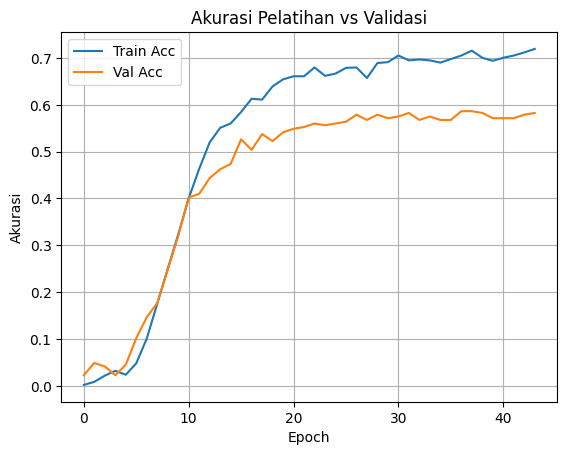

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Akurasi Pelatihan vs Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid()
plt.show()

In [3]:
import json
from keras.models import load_model

In [ ]:
# Simpan model
model.save("model_rnn_prediksi_kata.h5")

# Simpan kamus char_to_idx dan idx_to_word
with open("char_to_idx.json", "w") as f:
    json.dump(char_to_idx, f)

with open("idx_to_word.json", "w") as f:
    json.dump({str(k): v for k, v in idx_to_word.items()}, f)

print("Model dan kosakata berhasil disimpan.")

Model dan kosakata berhasil disimpan.


In [4]:
# Load model
model = load_model("model_rnn_prediksi_kata.h5")

# Load kamus
with open("char_to_idx.json") as f:
    char_to_idx = json.load(f)

with open("idx_to_word.json") as f:
    idx_to_word = {int(k): v for k, v in json.load(f).items()}

MAX_SEQUENCE_LENGTH = 10  # Atau sesuaikan dengan nilai aktual dari training
PAD_TOKEN = '_'

In [5]:
def predict_word(prefix):
    prefix = prefix.lower()
    prefix_chars = list(prefix)

    # Padding dengan '_'
    if len(prefix_chars) > MAX_SEQUENCE_LENGTH:
        prefix_chars = prefix_chars[:MAX_SEQUENCE_LENGTH]  # potong jika terlalu panjang
    else:
        prefix_chars += [PAD_TOKEN] * (MAX_SEQUENCE_LENGTH - len(prefix_chars))

    # Konversi ke indeks
    input_indices = [char_to_idx.get(char, char_to_idx[PAD_TOKEN]) for char in prefix_chars]
    input_array = np.array([input_indices])  # bentuk (1, MAX_SEQUENCE_LENGTH)

    # Prediksi
    prediction = model.predict(input_array, verbose=0)
    predicted_index = np.argmax(prediction)
    predicted_word = idx_to_word[predicted_index]

    return predicted_word

In [6]:
prefix_input = input("Masukkan awalan huruf: ")
hasil_prediksi = predict_word(prefix_input)
print(f"Prediksi kata dasar: {hasil_prediksi}")

Masukkan awalan huruf: b
Prediksi kata dasar: biru


In [7]:
def predict_top_k_words(prefix, k=5):
    prefix = prefix.lower()
    prefix_chars = list(prefix)

    # Padding dengan '_'
    if len(prefix_chars) > MAX_SEQUENCE_LENGTH:
        prefix_chars = prefix_chars[:MAX_SEQUENCE_LENGTH]
    else:
        prefix_chars += [PAD_TOKEN] * (MAX_SEQUENCE_LENGTH - len(prefix_chars))

    # Konversi ke indeks karakter
    input_indices = [char_to_idx.get(char, char_to_idx[PAD_TOKEN]) for char in prefix_chars]
    input_array = np.array([input_indices])  # shape (1, MAX_SEQUENCE_LENGTH)

    # Prediksi probabilitas kelas
    prediction_probs = model.predict(input_array, verbose=0)[0]  # bentuk (num_target_words,)

    # Ambil indeks top-k dengan probabilitas tertinggi
    top_k_indices = prediction_probs.argsort()[-k:][::-1]  # descending

    # Buat list (kata, probabilitas)
    top_k_words = [(idx_to_word[idx], prediction_probs[idx]) for idx in top_k_indices]

    return top_k_words

In [9]:
prefix_input = input("Masukkan awalan huruf: ")
top_k = 5

hasil = predict_top_k_words(prefix_input, k=top_k)
print(f"Prediksi {top_k} kata teratas untuk prefix '{prefix_input}':")
for word, prob in hasil:
    print(f"- {word} (Probabilitas: {prob:.4f})")

Masukkan awalan huruf: bi
Prediksi 5 kata teratas untuk prefix 'bi':
- biru (Probabilitas: 0.5720)
- bisa (Probabilitas: 0.1548)
- baik (Probabilitas: 0.0307)
- kita (Probabilitas: 0.0195)
- buku (Probabilitas: 0.0146)
